<a href="https://colab.research.google.com/github/ISEA-Repositories/MLsessions/blob/main/FairnessCompare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

- Two populations, A & B.
- A is less likely to have the outcome than B.
- Simulated Outcomes and Risk scores with perfect calibration
- Explore how various measures of fairness differ between the two groups


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Simulating data for populations A and B
np.random.seed(42)

N = 100000

# Simulating risk scores for populations A and B with different distributions
population_a_scores = np.random.normal(loc=0.45, scale=0.1, size=N)  # Lower mean for A
population_b_scores = np.random.normal(loc=0.6, scale=0.1, size=N)  # Higher mean for B

# Simulating binary outcomes (y_true) for calibration parity:
# We set the probability of the outcome being positive to match the risk score
y_true_a = (population_a_scores >= np.random.rand(N)).astype(int)
y_true_b = (population_b_scores >= np.random.rand(N)).astype(int)

# Add prediction labels
threshold = 0.5
y_pred_a = (population_a_scores >= threshold).astype(int)
y_pred_b = (population_b_scores >= threshold).astype(int)

# Convert to DataFrame for easier handling
data_a = pd.DataFrame({'population': 'A', 'risk_score': population_a_scores, 'y_true': y_true_a, 'y_pred':y_pred_a})
data_b = pd.DataFrame({'population': 'B', 'risk_score': population_b_scores, 'y_true': y_true_b, 'y_pred':y_pred_b})

# Combine data
data = pd.concat([data_a, data_b])

## Outcome Distribution and Risk Score Distribution

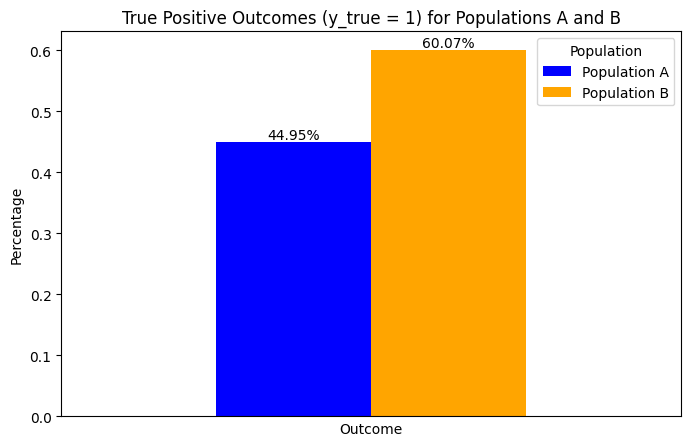

In [2]:
percentages = pd.concat([
    data_a['y_true'].value_counts(normalize=True),
    data_b['y_true'].value_counts(normalize=True)
], axis=1, keys=['Population A', 'Population B']).sort_index()

# Keep only the percentage for outcome = 1
percentages = percentages.loc[[1]]

# Plot the percentages
ax = percentages.plot(kind='bar', figsize=(8, 5), color=['blue', 'orange'])
plt.title('True Positive Outcomes (y_true = 1) for Populations A and B')
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.xticks([])  # Remove x-axis labels since there's only one category
plt.legend(title='Population')

# Annotate the bars with percentages
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.show()

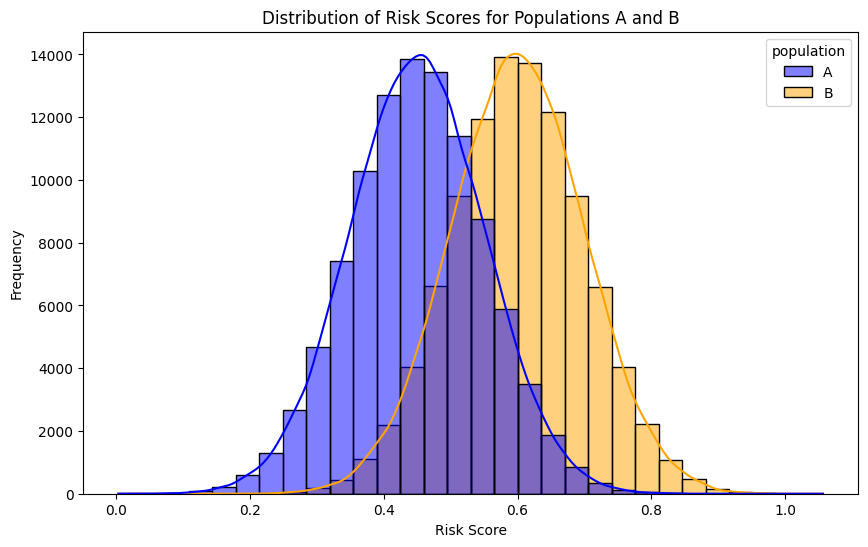

In [3]:
# Step 2: Plotting the distribution of risk scores for both populations
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='risk_score', hue='population', kde=True, bins=30, palette=['blue', 'orange'])
plt.title('Distribution of Risk Scores for Populations A and B')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()


## Accuracy

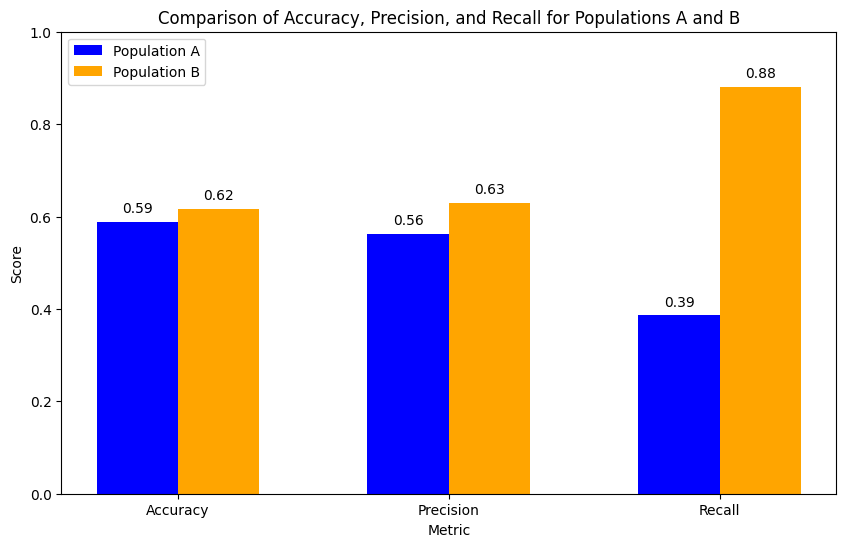

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate Accuracy, Precision, and Recall
def calculate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))  # True Positives
    TN = np.sum((y_true == 0) & (y_pred == 0))  # True Negatives
    FP = np.sum((y_true == 0) & (y_pred == 1))  # False Positives
    FN = np.sum((y_true == 1) & (y_pred == 0))  # False Negatives

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    return accuracy, precision, recall

# For Population A
accuracy_a, precision_a, recall_a = calculate_metrics(data_a['y_true'], data_a['y_pred'])

# For Population B
accuracy_b, precision_b, recall_b = calculate_metrics(data_b['y_true'], data_b['y_pred'])

# Step 2: Create a bar chart for Accuracy, Precision, and Recall
metrics_labels = ['Accuracy', 'Precision', 'Recall']
metrics_values_a = [accuracy_a, precision_a, recall_a]
metrics_values_b = [accuracy_b, precision_b, recall_b]

# Create the bar chart
width = 0.3  # Width of the bars
x = np.arange(len(metrics_labels))  # Label locations
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for both populations
ax.bar(x - width/2, metrics_values_a, width, label='Population A', color='blue')
ax.bar(x + width/2, metrics_values_b, width, label='Population B', color='orange')

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Accuracy, Precision, and Recall for Populations A and B')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

# Display the metric values on top of the bars
for i, value in enumerate(metrics_values_a):
    ax.text(i - width/2, value + 0.02, f'{value:.2f}', ha='center')
for i, value in enumerate(metrics_values_b):
    ax.text(i + width/2, value + 0.02, f'{value:.2f}', ha='center')

plt.ylim(0, 1)
plt.show()


Remember
- accuracy is `(True Positives + True Negatives) / Total Cases`
- precision is (not) overidentifying positive cases: `True Positives / (True Positives + False Positives)`
- recall is finding positive cases: `True Positives / (True Positives + False Negatives) `

# Confusion Matrix

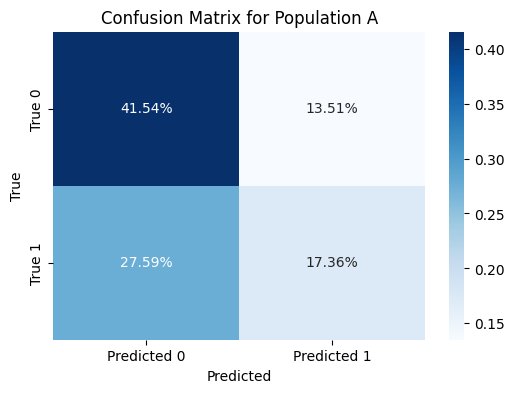

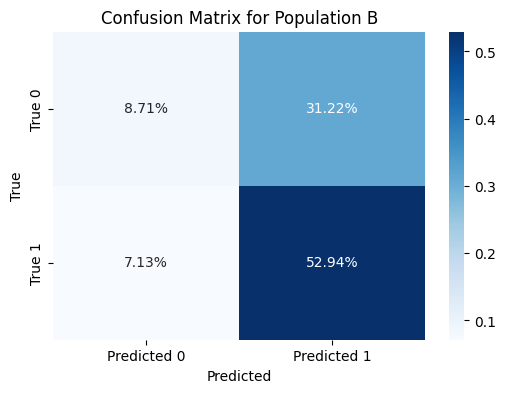

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Step 1: Calculate Confusion Matrix for both populations and convert to percentages
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm.astype('float') / cm.sum()  # Normalize by total number of samples

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_pct, annot=True, fmt=".2%", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# For Population A
plot_confusion_matrix(data_a['y_true'], data_a['y_pred'], title="Confusion Matrix for Population A")

# For Population B
plot_confusion_matrix(data_b['y_true'], data_b['y_pred'], title="Confusion Matrix for Population B")


A has a lower likelihood of the outcome than B and calibration is equal
- A has more True Negative
- B has more True Positive
- A has more False Negative
- B has more False Positive

## Calibration Parity
For a given risk score, the percentage of positive cases between two groups should be the same.

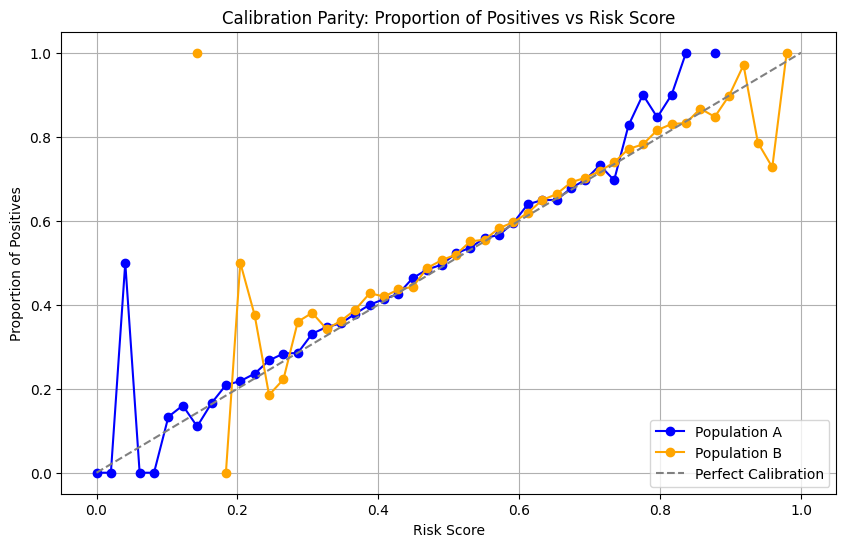

In [6]:
# Increased resolution by using smaller intervals
risk_score_bins = np.linspace(0, 1, 50)
calibration_a = []
calibration_b = []

for i in range(len(risk_score_bins)-1):
    lower, upper = risk_score_bins[i], risk_score_bins[i+1]

    # Proportion of positive outcomes for population A in each risk score bin
    calibration_a.append(np.mean(data_a[(data_a['risk_score'] >= lower) & (data_a['risk_score'] < upper)]['y_true']))

    # Proportion of positive outcomes for population B in each risk score bin
    calibration_b.append(np.mean(data_b[(data_b['risk_score'] >= lower) & (data_b['risk_score'] < upper)]['y_true']))

# Plotting Calibration Parity
plt.figure(figsize=(10, 6))
plt.plot(risk_score_bins[:-1], calibration_a, label='Population A', color='blue', marker='o')
plt.plot(risk_score_bins[:-1], calibration_b, label='Population B', color='orange', marker='o')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.title('Calibration Parity: Proportion of Positives vs Risk Score')
plt.xlabel('Risk Score')
plt.ylabel('Proportion of Positives')
plt.legend()
plt.grid(True)
plt.show()


This plot doesn't show data density, the edges where things get wonky have pretty thin data. Through the bulk of the data, calibration parity is pretty close to perfect.

# False Positive Rate

In [7]:
def false_positive_rate(y_true, y_pred):
    # False Positive Rate = FP / (FP + TN)
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    tn = np.sum((y_true == 0) & (y_pred == 0))  # True negatives
    return fp / (fp + tn)

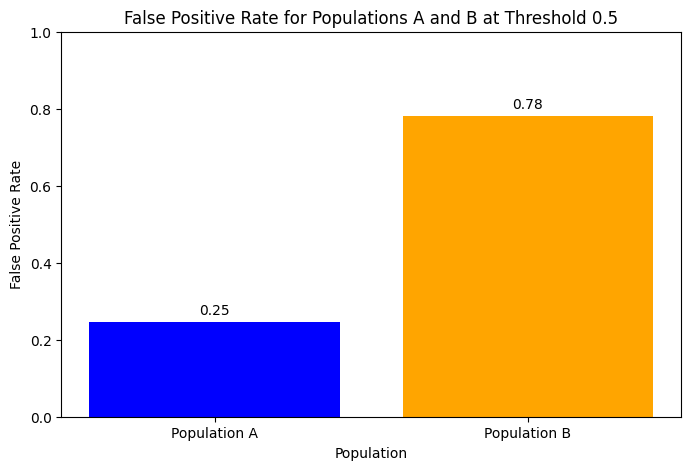

In [8]:
# For Population A
fpr_a = false_positive_rate(data_a['y_true'], data_a['y_pred'])

# For Population B
fpr_b = false_positive_rate(data_b['y_true'], data_b['y_pred'])

# Step 3: Create a bar chart for FPR
labels = ['Population A', 'Population B']
fpr_values = [fpr_a, fpr_b]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, fpr_values, color=['blue', 'orange'])
plt.xlabel('Population')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate for Populations A and B at Threshold 0.5')
plt.ylim(0, 1)

# Display the value of FPR on top of the bars
for i, value in enumerate(fpr_values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center')

plt.show()

Note in the confusion matrix above we showed the percentage of all cases that were TP, TN, FP, FN. Here we are showing the False Positive Rate (`FPR = FP / (FP + TN)`) - in other words the percentage of all negative cases that were wrongly identified as positive.

### What if we vary the threshold?

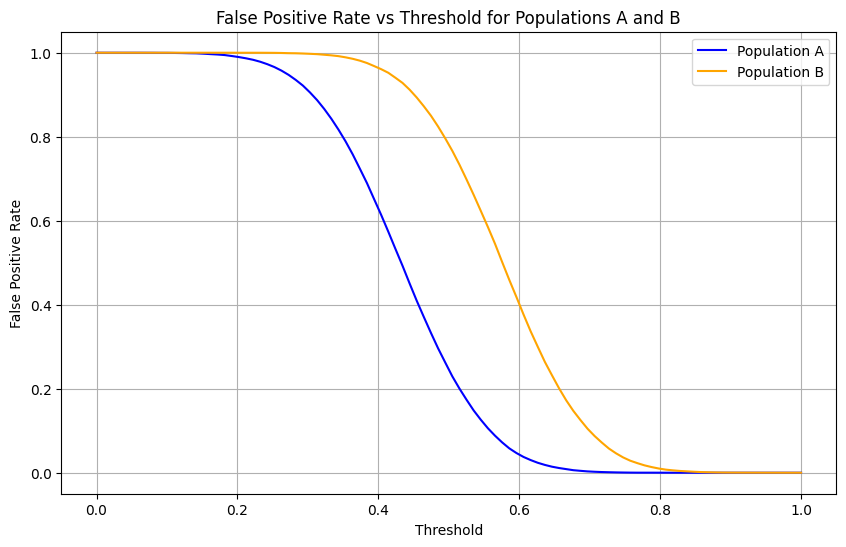

In [9]:


# Define the thresholds and calculate FPR at each threshold
thresholds = np.linspace(0, 1, 100)
fpr_a = []
fpr_b = []

for threshold in thresholds:
    # Classification based on threshold for population A
    y_pred_a = (data_a['risk_score'] >= threshold).astype(int)
    fpr_a.append(false_positive_rate(data_a['y_true'], y_pred_a))

    # Classification based on threshold for population B
    y_pred_b = (data_b['risk_score'] >= threshold).astype(int)
    fpr_b.append(false_positive_rate(data_b['y_true'], y_pred_b))

# Plotting False Positive Rate vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr_a, label='Population A', color='blue')
plt.plot(thresholds, fpr_b, label='Population B', color='orange')
plt.title('False Positive Rate vs Threshold for Populations A and B')
plt.xlabel('Threshold')
plt.ylabel('False Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# AUC
Aggregate measure of a model's ability to distinguish between the positive and negative classes across different decision thresholds.

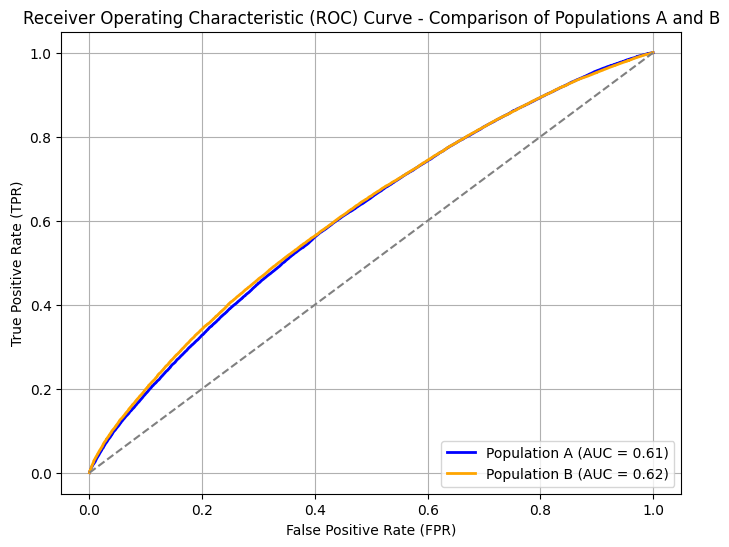

In [10]:
from sklearn.metrics import roc_curve, auc
# Extract the true labels and predicted probabilities (risk scores) for each population
y_true_a = data_a['y_true']
y_pred_prob_a = data_a['risk_score']

y_true_b = data_b['y_true']
y_pred_prob_b = data_b['risk_score']

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for each population
fpr_a, tpr_a, _ = roc_curve(y_true_a, y_pred_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_true_b, y_pred_prob_b)

# Calculate AUC (Area Under the Curve) for each population
roc_auc_a = auc(fpr_a, tpr_a)
roc_auc_b = auc(fpr_b, tpr_b)

# Plot ROC curves for both populations
plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, color='blue', lw=2, label=f'Population A (AUC = {roc_auc_a:.2f})')
plt.plot(fpr_b, tpr_b, color='orange', lw=2, label=f'Population B (AUC = {roc_auc_b:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.title('Receiver Operating Characteristic (ROC) Curve - Comparison of Populations A and B')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()